In [1]:
import tensorflow as tf

In [2]:
from data.dataloader import tf_data_generator
from models.losses import tf_loss_function_mat

In [3]:
from models.gru_denoiser import BiGRUSpectralDenoiserTensorFlow

In [4]:
from training.trainer import Trainer_tf

In [5]:
from estimator.QIS import tf_QIS_batched

In [6]:
import numpy as np
import matplotlib.pyplot as plt

## NN

In [7]:
def mse(A, B):
    A = tf.cast(A, tf.float32)
    B = tf.cast(B, tf.float32)
    return tf.reduce_mean(tf.square(A - B))

In [8]:
N_min = 70
N_max = 250
T_min = 30
T_max = 70
batch_size=100

### Training loop — Generated Data

In [9]:
model_generated_data = BiGRUSpectralDenoiserTensorFlow(hidden_size=96) # hidden_size to be tunned 
# lr, weight_decay, batch_size, epochs, hidden_size to be tunned

In [10]:
trainer = Trainer_tf(
    model=model_generated_data, is_train_on_real_data = False, loss_function=tf_loss_function_mat, data_generator=tf_data_generator, lr = 1e-4, weight_decay=1e-5,
    batch_size=batch_size, epochs=50, N_min=N_min, N_max=N_max, T_min=T_min, T_max=T_max, log_interval=10, accumulate_steps=2, dataset=None, missing_constant = 2,
)
# need to epochs to be big when there is lot of choise for N and T 
# need for big batch_size when df is big
losses = trainer.train()

Starting training for 50 epochs…
Epoch 10/50 — loss: 0.02535026
Epoch 20/50 — loss: 0.01344470
Epoch 30/50 — loss: 0.01396163
Epoch 40/50 — loss: 0.01457937
Epoch 50/50 — loss: 0.01607797
Training complete.


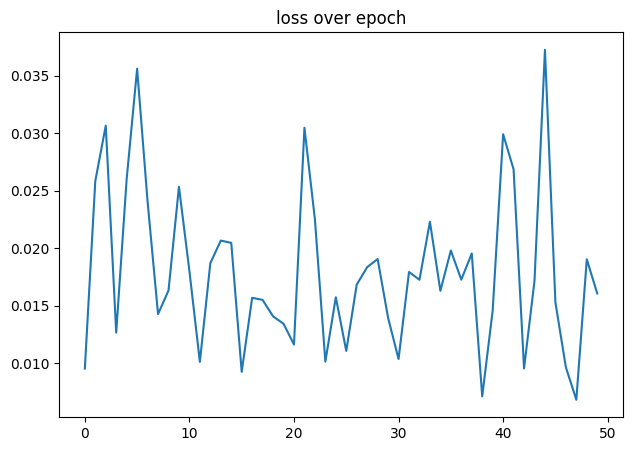

In [11]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(losses)
plt.title("loss over epoch")
plt.savefig("images/training_loss.png")
plt.show()

### Comparaison (oos)

In [12]:
batch_size_oos = 500

In [13]:
input_seq_cov_miss, Q_emp_miss, Sigma_true_miss, T, Sigma_hat_diag_miss, R_miss          = next(tf_data_generator(batch_size_oos, missing_constant = 2, N_min=60, N_max=60, T_min=30, T_max=30))
input_seq_cov_no_miss, Q_emp_no_miss, Sigma_true_no_miss, T, Sigma_hat_diag_no_miss, R_no_miss = next(tf_data_generator(batch_size_oos, missing_constant = 1, N_min=60, N_max=60, T_min=30, T_max=30))

In [14]:
lam_emp_miss     = input_seq_cov_miss[:,:,0]
lam_pred_miss    = model_generated_data(input_seq_cov_miss) # ,lam_emp_miss
lam_emp_no_miss  = input_seq_cov_no_miss[:,:,0]
lam_pred_no_miss = model_generated_data(input_seq_cov_no_miss) # ,lam_emp_no_miss

In [15]:
lam_emp_miss[0]

<tf.Tensor: shape=(60,), dtype=float32, numpy=
array([-0.51967686, -0.43502584, -0.40078196, -0.3156343 , -0.29153815,
       -0.26221156, -0.22311993, -0.20159486, -0.18994778, -0.17551684,
       -0.17009488, -0.13864668, -0.12269672, -0.11136518, -0.10334758,
       -0.08980863, -0.08861315, -0.07790706, -0.07349844, -0.06841782,
       -0.05887022, -0.05530147, -0.05369147, -0.04849797, -0.0448396 ,
       -0.0398489 , -0.03675294, -0.03301958, -0.0327514 , -0.0293103 ,
       -0.02765005, -0.02534682, -0.01318855,  0.09437586,  0.18310308,
        0.29071534,  0.4237539 ,  0.5328143 ,  0.6819113 ,  0.8743574 ,
        0.9206779 ,  1.0614207 ,  1.1397731 ,  1.3474221 ,  1.3988184 ,
        1.6282322 ,  1.8349113 ,  2.0325382 ,  2.4476857 ,  2.6835504 ,
        2.9231725 ,  3.5275521 ,  3.6770084 ,  3.9472256 ,  4.023408  ,
        4.4846935 ,  4.902116  ,  5.052565  ,  6.020095  ,  6.424617  ],
      dtype=float32)>

In [16]:
lam_pred_miss[0]

<tf.Tensor: shape=(60,), dtype=float32, numpy=
array([1.0102006 , 0.9777981 , 0.94647306, 0.9828802 , 0.96922994,
       0.9216014 , 0.92702794, 0.9439028 , 0.96169657, 0.92795706,
       0.9532699 , 0.93567646, 0.9709252 , 0.9577823 , 0.9323741 ,
       0.94981843, 0.9652613 , 0.9201625 , 0.9613545 , 1.0117621 ,
       0.98663306, 1.020031  , 0.981778  , 0.94166535, 0.9547089 ,
       0.9569447 , 1.0618256 , 0.9957335 , 1.0037292 , 1.0608169 ,
       1.0484166 , 0.9229583 , 0.9128515 , 0.8931249 , 0.90472686,
       0.9857203 , 0.921779  , 0.96407026, 0.9771496 , 1.0017496 ,
       1.0215597 , 0.9676719 , 1.0307803 , 1.0539372 , 1.0601951 ,
       0.9832662 , 1.050918  , 1.0548785 , 1.056867  , 1.0867618 ,
       1.092073  , 1.0540637 , 1.0814813 , 1.0989525 , 1.1098593 ,
       1.0998368 , 1.1303786 , 1.1004205 , 1.1398481 , 1.1026835 ],
      dtype=float32)>

Comparaison matrix $Corr$

In [17]:
# Corr from predicted eigenvalues
Corr_pred_miss = tf.matmul(
    tf.matmul(Q_emp_miss, tf.linalg.diag(lam_pred_miss)),
    Q_emp_miss,
    transpose_b=True
)

Corr_pred_no_miss = tf.matmul(
    tf.matmul(Q_emp_no_miss, tf.linalg.diag(lam_pred_no_miss)),
    Q_emp_no_miss,
    transpose_b=True
)

# Corr from empirical eigenvalues
Corr_emp_miss = tf.matmul(
    tf.matmul(Q_emp_miss, tf.linalg.diag(lam_emp_miss)),
    Q_emp_miss,
    transpose_b=True
)

Corr_emp_no_miss = tf.matmul(
    tf.matmul(Q_emp_no_miss, tf.linalg.diag(lam_emp_no_miss)),
    Q_emp_no_miss,
    transpose_b=True
)

In [18]:
# MISS
diag_oos_miss = tf.linalg.diag_part(Sigma_true_miss)
std_oos_miss = tf.sqrt(tf.maximum(diag_oos_miss, 1e-12))
Corr_true_miss = Sigma_true_miss / (
    std_oos_miss[:, None, :] * std_oos_miss[:, :, None] + 1e-12
)

# NO MISS
diag_oos_no_miss = tf.linalg.diag_part(Sigma_true_no_miss)
std_oos_no_miss = tf.sqrt(tf.maximum(diag_oos_no_miss, 1e-12))
Corr_true_no_miss = Sigma_true_no_miss / (
    std_oos_no_miss[:, None, :] * std_oos_no_miss[:, :, None] + 1e-12
)

In [19]:
fro_Corr_pred_miss    = mse(Corr_pred_miss, Corr_true_miss)
fro_Corr_pred_no_miss = mse(Corr_pred_no_miss, Corr_true_no_miss)
fro_Corr_emp_miss     = mse(Corr_emp_miss, Corr_true_miss)
fro_Corr_emp_no_miss  = mse(Corr_emp_no_miss, Corr_true_no_miss)

In [20]:
print(f"MSE Corr after miss + NN:         {fro_Corr_pred_miss.numpy():.6f}")
print(f"MSE Corr after no miss + NN :     {fro_Corr_pred_no_miss.numpy():.6f}")
print(f"MSE Corr after miss + no NN :     {fro_Corr_emp_miss.numpy():.6f}")
print(f"MSE Corr after no miss  + no NN : {fro_Corr_emp_no_miss.numpy():.6f}")

MSE Corr after miss + NN:         0.000493
MSE Corr after no miss + NN :     0.000584
MSE Corr after miss + no NN :     0.053839
MSE Corr after no miss  + no NN : 0.033898


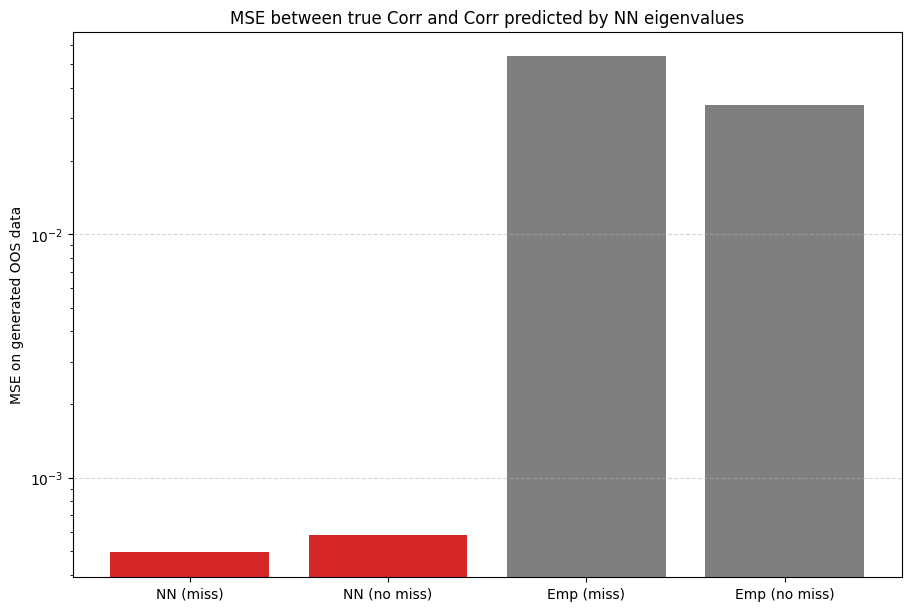

In [21]:
labels = ['NN (miss)', 'NN (no miss)', 'Emp (miss)', 'Emp (no miss)']
values = [
    fro_Corr_pred_miss.numpy(),
    fro_Corr_pred_no_miss.numpy(),
    fro_Corr_emp_miss.numpy(),
    fro_Corr_emp_no_miss.numpy(),
]

colors = ['tab:red','tab:red','tab:gray','tab:gray']

plt.figure(figsize=(9,6), constrained_layout=True)
plt.bar(labels, values, color=colors)
plt.yscale('log')
plt.ylabel('MSE on generated OOS data')
plt.title("MSE between true Corr and Corr predicted by NN eigenvalues")
plt.grid(axis='y', ls='--', alpha=.5)
plt.show()

In [22]:
D_miss = tf.cast(tf.sqrt(tf.linalg.diag(Sigma_hat_diag_miss)), tf.float32)
D_no_miss = tf.cast(tf.sqrt(tf.linalg.diag(Sigma_hat_diag_no_miss)), tf.float32)

Corr_pred_miss = tf.cast(Corr_pred_miss, tf.float32)
Corr_pred_no_miss = tf.cast(Corr_pred_no_miss, tf.float32)
Corr_emp_miss = tf.cast(Corr_emp_miss, tf.float32)
Corr_emp_no_miss = tf.cast(Corr_emp_no_miss, tf.float32)

Sigma_pred_miss = tf.matmul(tf.matmul(D_miss, Corr_pred_miss), D_miss)
Sigma_pred_no_miss = tf.matmul(tf.matmul(D_no_miss, Corr_pred_no_miss), D_no_miss)
Sigma_emp_miss = tf.matmul(tf.matmul(D_miss, Corr_emp_miss), D_miss)
Sigma_emp_no_miss = tf.matmul(tf.matmul(D_no_miss, Corr_emp_no_miss), D_no_miss)


In [23]:
Sigma_QIS = tf_QIS_batched(R_no_miss)

lam_QIS, _ = tf.linalg.eigh(Sigma_QIS)
eigv, _ = tf.linalg.eigh(Sigma_true_no_miss)

In [24]:
fro_Sigma_pred_miss    = mse(Sigma_pred_miss, Sigma_true_miss)
fro_Sigma_pred_no_miss = mse(Sigma_pred_no_miss, Sigma_true_no_miss)
fro_Sigma_emp_miss     = mse(Sigma_emp_miss, Sigma_true_miss)
fro_Sigma_emp_no_miss  = mse(Sigma_emp_no_miss, Sigma_true_no_miss)
fro_Sigma_QIS          = mse(Sigma_QIS, Sigma_true_no_miss)

In [25]:
print(f"MSE Sigma after miss + NN:         {fro_Sigma_pred_miss.numpy():.6f}")
print(f"MSE Sigma after no miss + NN :     {fro_Sigma_pred_no_miss.numpy():.6f}")
print(f"MSE Sigma after miss + no NN :     {fro_Sigma_emp_miss.numpy():.6f}")
print(f"MSE Sigma after no miss  + no NN : {fro_Sigma_emp_no_miss.numpy():.6f}")
print(f"MSE Sigma QIS :                    {fro_Sigma_QIS.numpy():.6f}")

MSE Sigma after miss + NN:         0.002113
MSE Sigma after no miss + NN :     0.001728
MSE Sigma after miss + no NN :     0.055664
MSE Sigma after no miss  + no NN : 0.035052
MSE Sigma QIS :                    0.001194


/var/folders/l1/kv6fjcx118x75w1kjzdxphsm0000gp/T/ipykernel_68489/132896052.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


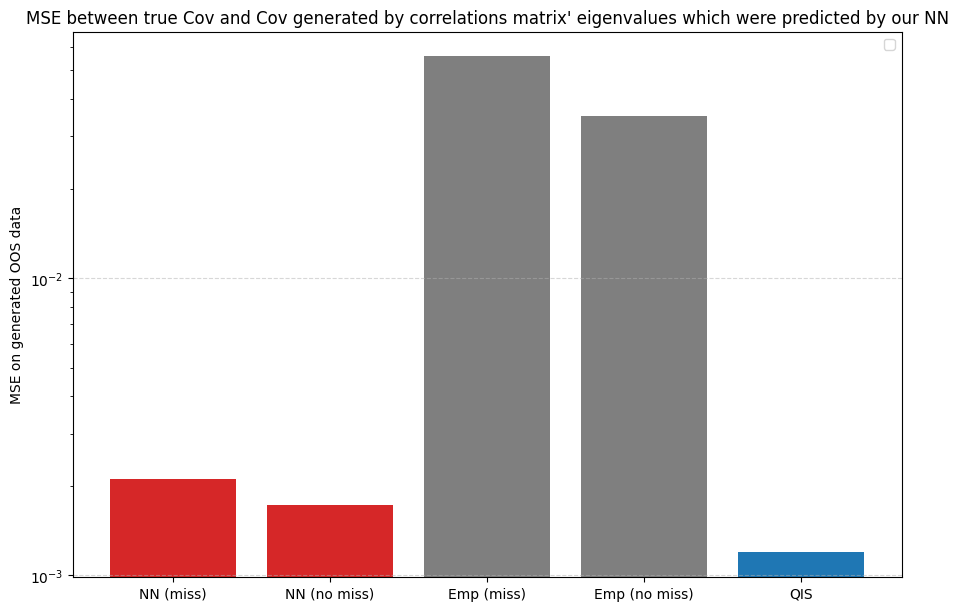

In [26]:
labels = ['NN (miss)', 'NN (no miss)', 'Emp (miss)', 'Emp (no miss)', 'QIS']# 'projected Em (miss)' 'projected Em (no miss)']
values = [fro_Sigma_pred_miss.numpy(), fro_Sigma_pred_no_miss.numpy(), fro_Sigma_emp_miss.numpy(), fro_Sigma_emp_no_miss.numpy(), fro_Sigma_QIS.numpy()]# fro_Sigma_near_miss.item(), fro_Sigma_near_no_miss.item()]
colors = ['tab:red','tab:red','tab:gray','tab:gray', 'tab:blue']#,, 'tab:gray''tab:gray']

plt.figure(figsize=(9,6), constrained_layout=True)
plt.bar(labels, values, color=colors)
plt.yscale('log')
plt.ylabel('MSE on generated OOS data')
plt.title("MSE between true Cov and Cov generated by correlations matrix' eigenvalues which were predicted by our NN")
plt.grid(axis='y', ls='--', alpha=.5)
plt.legend()
plt.show()
